In [1]:
#libraries
import os 
import pandas as pd
import numpy as np 
import h5py
import math
import collections
import filecmp
from lxml import etree as ET
#import xml.etree.ElementTree as ET
import datetime
from collections import OrderedDict
#import pandasql as ps
from operator import itemgetter
import csv
from collections import Counter
#from google.colab import drive

import geopandas as gpd
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy
import fiona

from scipy.stats import kstest
from scipy.stats import mannwhitneyu

#from dill.source import getsource
import json

# load csv module
import csv

In [6]:
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')

In [133]:
test_dt = pd.read_csv('demo_group_dt_land_use_hm.csv', index_col=0)
persons_ = pd.read_csv('per_with_demo.csv', index_col=0)
persons_ = persons_[['person_id', 'hhno', 'demo_num', 'demo_noage']]

In [123]:
##get trips data
##get taz for each hhno
hdf_file = h5py.File(r'daysim_outputs.h5', "r")

# output_dir = r'\\modelstation3\c$\\Workspace\sc_new_emp_SCEN3_2018'
# print(hdf_file.keys())

def h5_to_data_frame(h5file, table_name):
    table = h5file[table_name]
    col_dict = {}
    #cols = ['hhno', 'hhtaz']
    for col in table.keys():
        if col == 'sov_ff_time':
            pass
        else:
            my_array = np.asarray(table[col]).astype('int')
        col_dict[col] = my_array.astype('int')
    return(pd.DataFrame(col_dict))
# Get the tables: trips, person, household, tours
#get trip data
trips = h5_to_data_frame(hdf_file, 'Trip')

# get trips columns to  use later
trips_columns = trips.columns
trips['person_id'] = trips['hhno'].astype(str) + '_' + trips['pno'].astype(str)

person_id_home = np.unique(trips['person_id'][(trips['opurp']==0)&(trips['otaz'].isin(selected_taz))])
#get otaz

trips = trips[['person_id','hhno', 'otaz','opurp']][trips['opurp']==0]

trips = trips.groupby(by=['hhno', 'otaz']).size().to_frame()
trips.reset_index(inplace=True)
trips = trips[['hhno', 'otaz']]


#get selected tazs
path= 'G:/My Drive/2021/Bias/SUMO_simulation/MatSumo-main/SUMO/SUMO_network/'
datafile = 'Taz_with_pseudo_link.add.xml'
tree = ET.parse(path+datafile)
root = tree.getroot()
selected_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    #filter out pseudo taz
    if len(tazid) <=3:
        selected_taz.append(int(tazid))
        
        
#get fcd data
path = "G:/My Drive/2021/Bias/sumo_simulation/appsim/"
#os.listdir(path)csv_path = '../data-1670309862526.csv'
fcd_dt_path = 'fcd_output_10per_all_30sec.csv'
fcd_out = pd.read_csv(path+fcd_dt_path, header=None)
fcd_out.columns = ['id', 'taz', 'time']

revise_dt = lambda x: x.split('-')[0] if '-' in x else x
get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3

fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
fcd_out.head(3)

print((fcd_out.groupby(by=['reids', 'sample_index']).size().to_frame().reset_index()).groupby(['sample_index']).size())

#check the index
print(np.unique(fcd_out['sample_index']))


#select the ids
select_ids = np.unique(fcd_out['reids'][fcd_out['sample_index']==1])

#only select stay instead of stay left
stays_ = pd.read_csv(path+'staysall.csv', header=None)
stays_.columns = ['reids', 'taz']

select_ids = list(select_ids)
for i in stays_['reids']:
    if i in select_ids:
        print(i)
    else:
        select_ids.append(i)
        
#get taz for each hhno
hhno_taz = {}
for i in range(trips.shape[0]):
    if trips['hhno'].values[i] not in hhno_taz:
        hhno_taz[trips['hhno'].values[i]] = trips['otaz'].values[i]

<KeysViewHDF5 ['Household', 'HouseholdDay', 'Person', 'PersonDay', 'Tour', 'Trip']>


In [141]:
get_taz = lambda x: hhno_taz[x]

In [142]:
persons_['otaz'] = persons_['hhno'].apply(get_taz)

In [151]:
persons_ = persons_[persons_['person_id'].isin(select_ids)]

In [152]:
persons_.head(3)

,person_id,hhno,demo_num,demo_noage,otaz
167849,67016_1,67016,20,5,3694
257244,102011_1,102011,19,4,291
257271,102038_1,102038,5,5,294


In [161]:
#get person who lives in the taz
persons_ = persons_[persons_['otaz'].isin(selected_taz)]

In [163]:
person_demo = persons_.groupby(by=['otaz', 'demo_num']).size().to_frame()
person_demo_age = persons_.groupby(by=['otaz', 'demo_noage']).size().to_frame()



In [169]:
person_sim_sum = person_demo.groupby(by=['otaz']).sum()
person_sim_sum.reset_index(inplace=True)

In [198]:
person_sim_sum['otaz']

0      426
1      427
2      428
3      429
4      430
      ... 
119    627
120    628
121    629
122    631
123    653
Name: otaz, Length: 124, dtype: int64

In [200]:
test_dt[test_dt['TAZ'].isin(selected_taz)]

,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,demo_level_9,...,demo_age_18,demo_age_19,demo_age_20,demo_age_21,demo_age_22,demo_age_23,demo_age_24,rate_cut_jenkc4,rate_cut_jenkc5,rate_cut_jenkc6
414,426,11,62,5,88,253,5,63,361,8,...,17,27,37,13,45,26,3,c1,c2,c2
415,427,23,21,1,237,493,3,176,423,18,...,25,76,115,20,51,16,1,c1,c1,c1
416,428,15,60,8,180,527,2,135,561,41,...,43,40,139,31,59,81,3,c1,c1,c1
536,551,2,7,1,88,165,0,63,159,14,...,19,16,51,10,9,19,0,c1,c1,c2
537,552,1,13,1,39,54,0,19,40,1,...,2,7,6,1,3,0,0,c2,c2,c2
552,567,3,32,7,143,137,3,86,136,7,...,10,21,14,1,13,2,0,c1,c1,c1
569,580,2,10,2,46,57,1,23,42,1,...,3,17,17,1,41,57,1,c1,c1,c1
595,605,70,37,0,101,111,11,75,121,30,...,5,19,14,0,24,12,2,c2,c2,c2


In [188]:
taz_dt = (test_dt[test_dt['TAZ'].isin(selected_taz)].set_index('TAZ')).join(person_sim_sum.set_index(['otaz']))
taz_dt.reset_index(inplace=True)

In [196]:
taz_dt

,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,demo_level_9,...,demo_age_19,demo_age_20,demo_age_21,demo_age_22,demo_age_23,demo_age_24,rate_cut_jenkc4,rate_cut_jenkc5,rate_cut_jenkc6,0
0,426,11,62,5,88,253,5,63,361,8,...,27,37,13,45,26,3,c1,c2,c2,43
1,427,23,21,1,237,493,3,176,423,18,...,76,115,20,51,16,1,c1,c1,c1,64
2,428,15,60,8,180,527,2,135,561,41,...,40,139,31,59,81,3,c1,c1,c1,85
3,551,2,7,1,88,165,0,63,159,14,...,16,51,10,9,19,0,c1,c1,c2,18
4,552,1,13,1,39,54,0,19,40,1,...,7,6,1,3,0,0,c2,c2,c2,10
5,567,3,32,7,143,137,3,86,136,7,...,21,14,1,13,2,0,c1,c1,c1,20
6,580,2,10,2,46,57,1,23,42,1,...,17,17,1,41,57,1,c1,c1,c1,17
7,605,70,37,0,101,111,11,75,121,30,...,19,14,0,24,12,2,c2,c2,c2,34


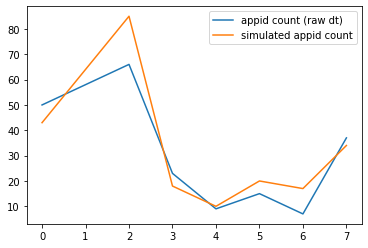

In [195]:
plt.plot(taz_dt['appid_count'].values, label='appid count (raw dt)')
plt.plot(taz_dt[0].values, label='simulated appid count')

plt.legend()

In [192]:
for i in taz_dt.columns:
    print(i)

TAZ
demo_level_1
demo_level_2
demo_level_3
demo_level_4
demo_level_5
demo_level_6
demo_level_7
demo_level_8
demo_level_9
demo_level_10
demo_level_11
demo_level_12
demo_level_13
demo_level_14
demo_level_15
demo_level_16
demo_level_17
demo_level_18
demo_level_19
demo_level_20
demo_level_21
demo_level_22
demo_level_23
demo_level_24
demo_level_25
demo_level_26
demo_level_27
demo_level_28
demo_level_29
demo_level_30
appid_count
COUNTY_FIP
COUNTY_NM
Area
geometry
TAZ1
psrc_sum
sumup_psrc_demo
sum_demo_rate
taz_p_x
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
taz_p_y
aparks
empedu_p
empfoo_p
empgov_p
empind_p
empmed_p
empofc_p
empoth_p
empret_p
emprsc_p
empsvc_p
emptot_p
hh_p
mfunits
nparks
parkdy_p
parkhr_p
sfunits
sqft_p
stugrd_p
stuhgh_p
stuuni_p
taz_p_x.1
ppricdyp
pprichrp
taz_p_y.1
lutype_p
land_use_h_sum
land_home_rate
rate_cut_jenkc3
rate_cut_jenkc2
demo1
demo2
demo3
demo4
demo5
demo6
demo7
demo8
demo9
demo10
demo11
demo12
demo13
demo14
demo15
demo_ag